# Script for plotting input-input and input-output correlations

In [1]:
'''
This section is simply for installing the seaborn package because it is not available by default in my notebook.

Seaborn is a great data science plotting library: https://seaborn.pydata.org/index.html

This section of the code is sourced from Jasmin's support site: https://github.com/cedadev/ceda-notebooks/blob/master/notebooks/training/intro/notebook-tour-part-6.ipynb

'''


# Import the required packages
import virtualenv
import pip
import os

# Define and create the base directory install virtual environments
venvs_dir = os.path.join(os.path.expanduser("~"), "nb-venvs")

if not os.path.isdir(venvs_dir):
    os.makedirs(venvs_dir)
    
# Define the venv directory
venv_dir = os.path.join(venvs_dir, 'venv-notebook')


if not os.path.isdir(venv_dir):
    # Create the virtual environment
    print(f'[INFO] Creating: virtual env at: {venv_dir}')
    virtualenv.create_environment(venv_dir)
    
    
# Activate the venv
activate_file = os.path.join(venv_dir, "bin", "activate_this.py")
exec(open(activate_file).read(), dict(__file__=activate_file))


# First let's assert that we cannot import `fixnc`
try:
    import seaborn
except ModuleNotFoundError as err:
    print('Failed to import "seaborn" as expected')
    
    
# pip install a package using the venv as a prefix
pip.main(["install", "--prefix", venv_dir, "seaborn"])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


You should consider upgrading via the '/opt/jaspy/bin/python -m pip install --upgrade pip' command.


0

In [2]:
# import useful packages

from sklearn import linear_model
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy.io.shapereader as shpreader
import shapely.geometry
import pandas as pd
import os
import seaborn as sns

In [4]:
# Safely create a folder called plots where images can be saved.
if not os.path.exists('plots'):
    os.makedirs('plots')

In [5]:
def read_data(filename):
    '''
    This script is for reading the input and output csv/dat files and transforming them into a pandas dataframe with floats.
    
    Args:
    
     - filename: The name of the dat/csv file, with the complete path if it is not in the same directory as this script.
    
    Returns:
    
     - df: File converted to pandas dataframe
    
    '''
    #The file is read as a pandas dataframe, with the first row = column names and first column = index names.
    
    df = pd.read_csv(filename, header = 0, index_col = 0) 
    
    # The elements are str type by default so they have to be converted to float.
    
    df = df.astype(float)
    return(df)

In [6]:
# Read data
# X = inputs in this case
# Y = outputs

X = read_data("X.dat")
Y = read_data("Y.dat")

In [8]:
# Filter data
# You can check the variables stored in X by looking at X.columns


# Here you can filter the data by variable names
x = X[['wind10', 'wind100', 'mx2t', 'mn2t', 't2m', 'msl', 'ssrd', 'week', 'year']]

# Here you can filter the data by the values of a certain column
# In this case, I am collecting data every 5 years from 1980 to 2000 but any other filter can be used

x = x.loc[x['year'].isin([1980.0, 1985.0, 1990.0, 1995.0, 2000.0])]


# Input-input correlation

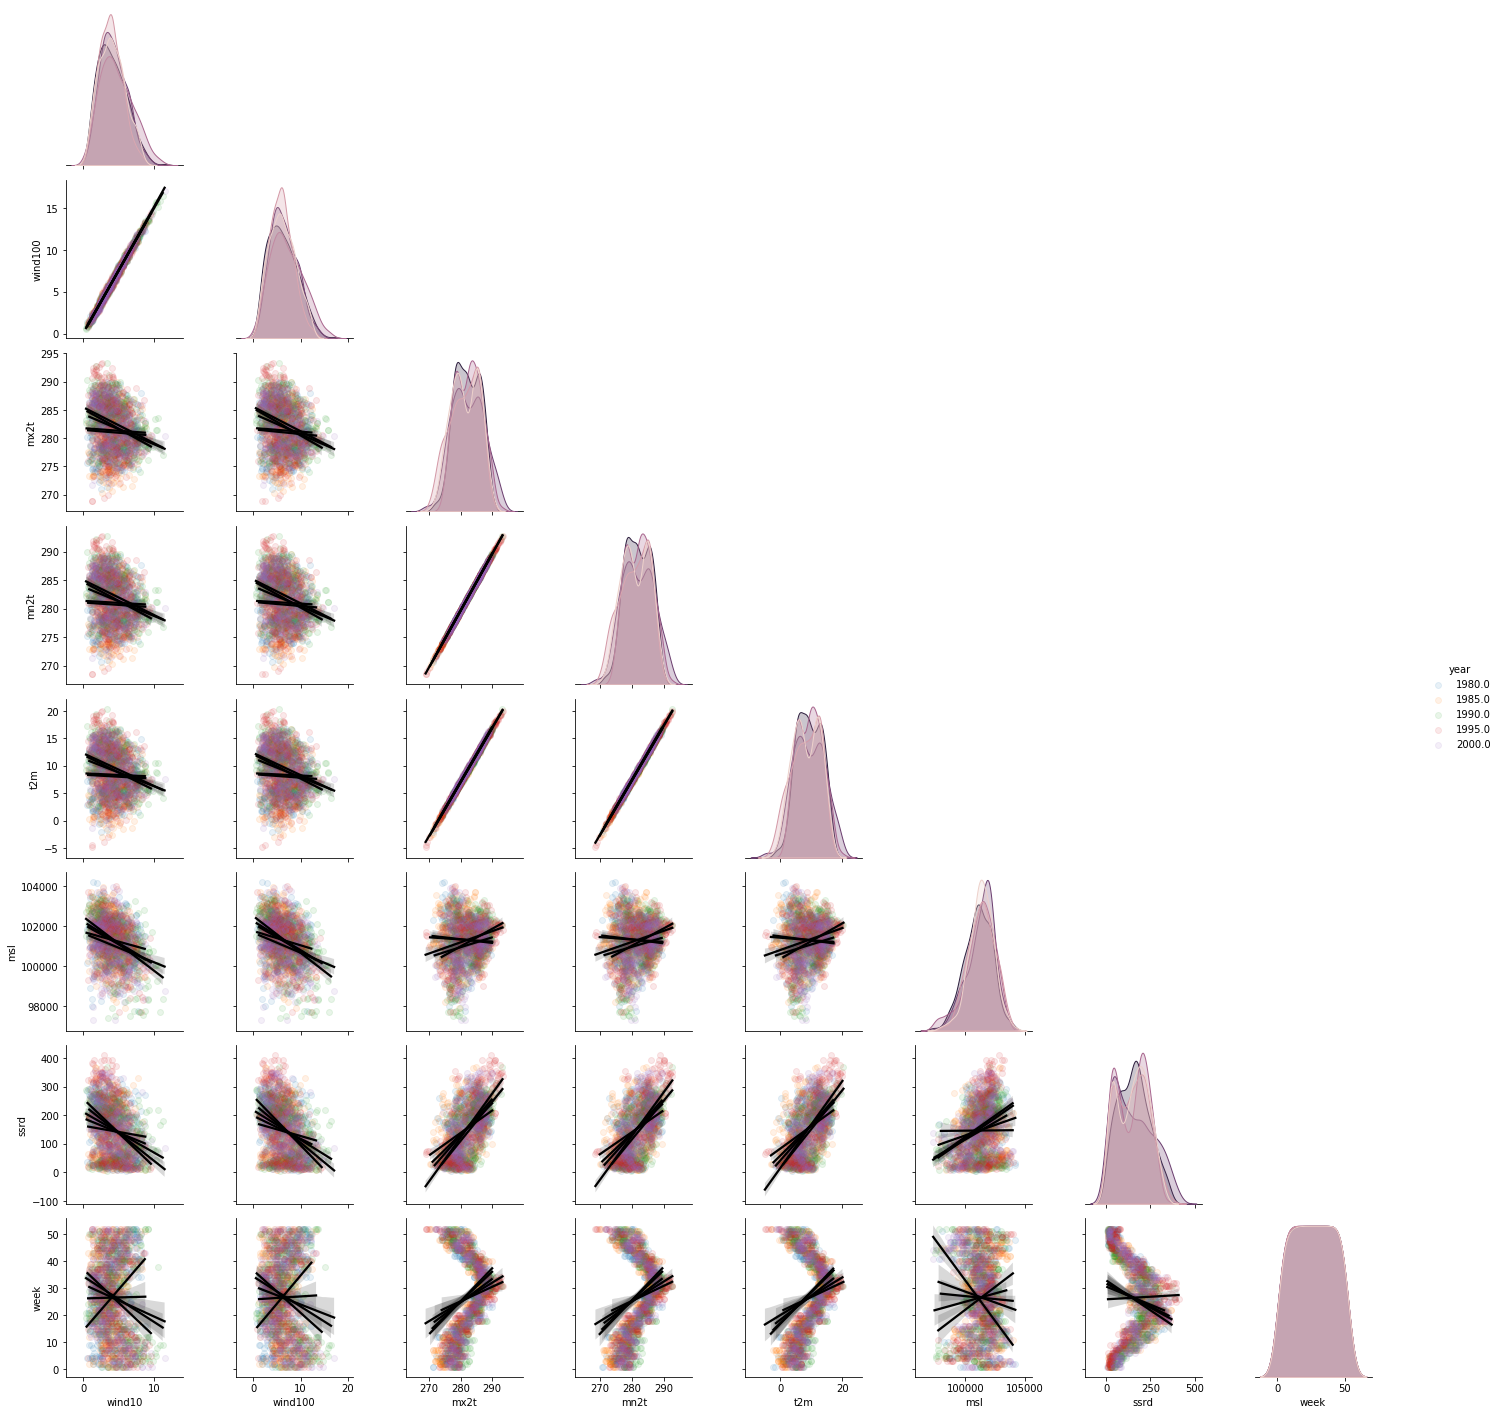

In [9]:
# Plot correlations between different inputs in the form of scatter plots with regression lines for each years
# The PDF of each variable is plotted on the diagonal

sns_plot = sns.pairplot(x, hue = 'year', kind='reg', plot_kws={'line_kws':{'color':'k'}, 'scatter_kws': {'alpha': 0.1}} , corner = True)
sns_plot.savefig("plots/yearwise_input-input_correlation_with_regression_lines.png")

The same plot as before, without the regression lines

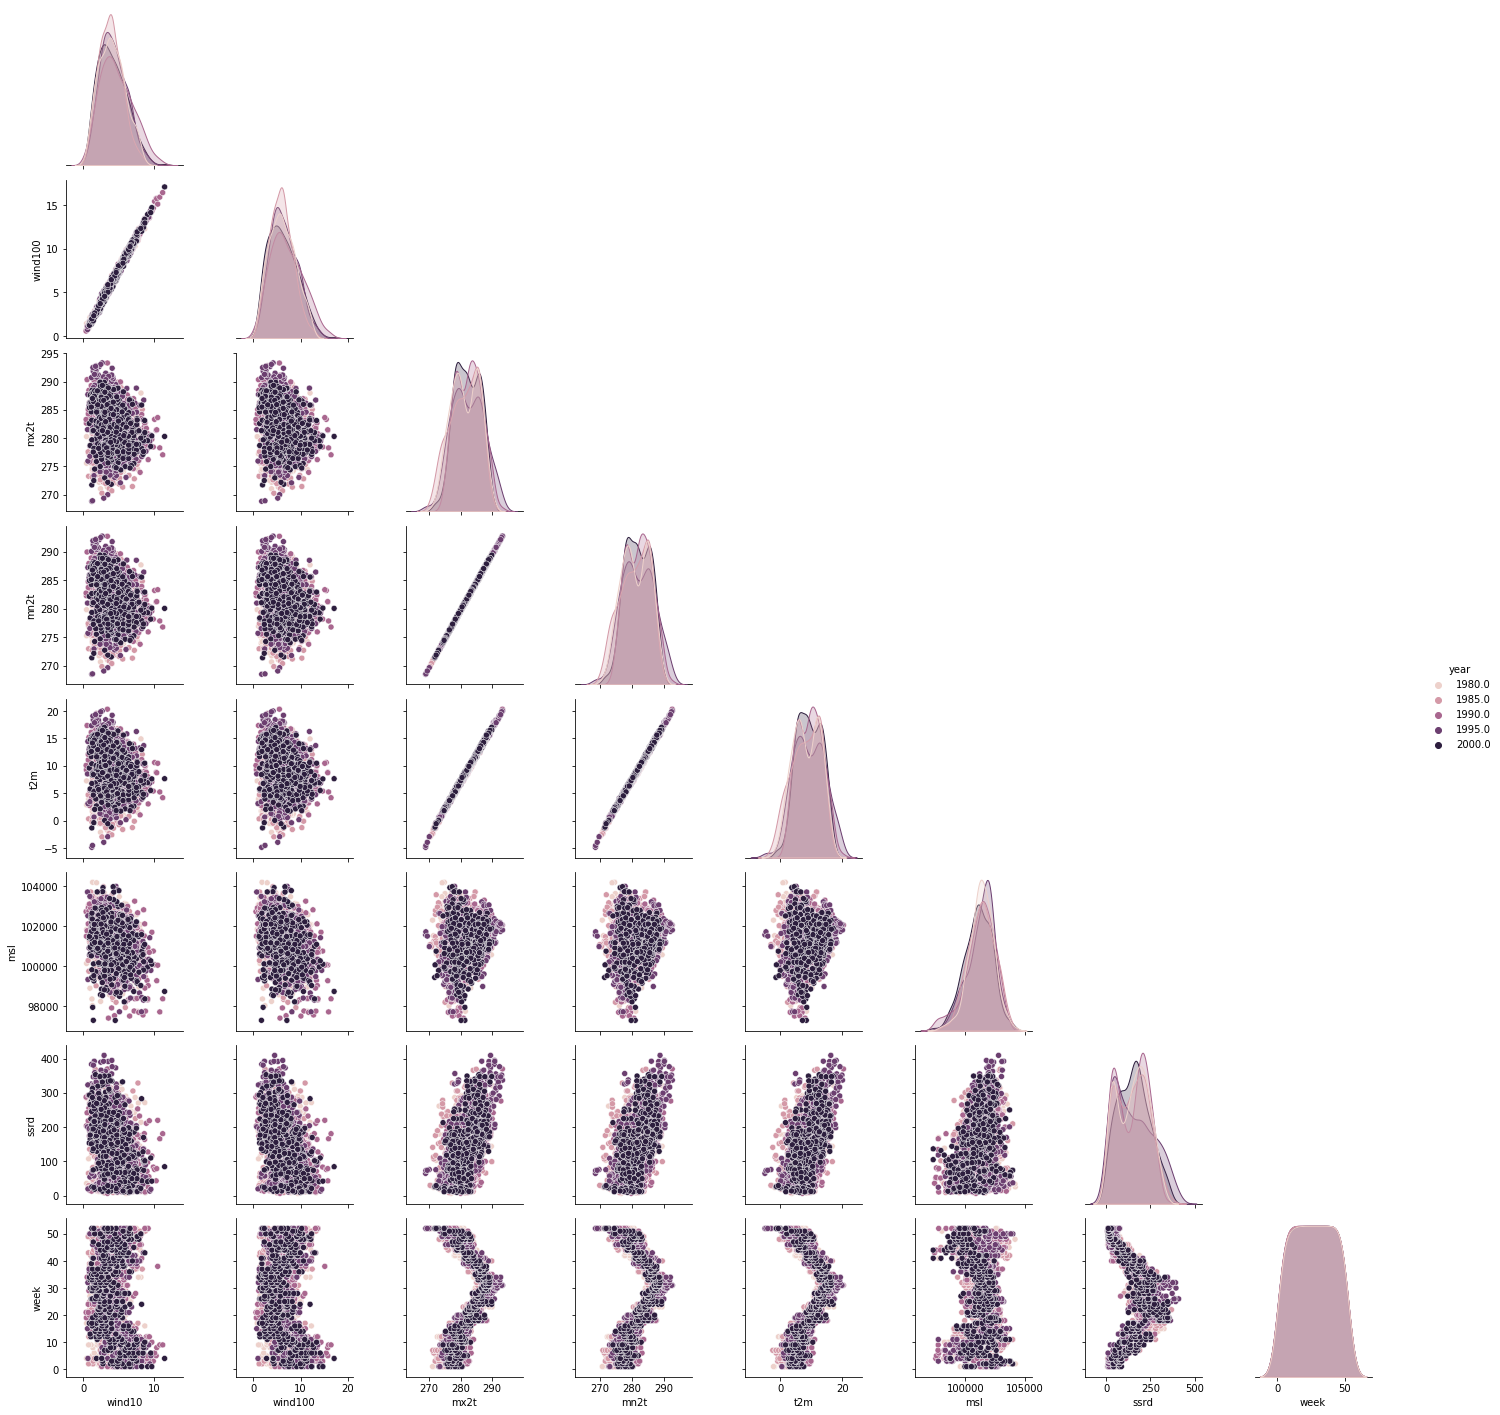

In [10]:
sns_plot = sns.pairplot(x, hue = 'year' , corner = True)
sns_plot.savefig("plots/yearwise_input-input_correlation.png")

# NOTES: 

- it seems that Tmin, Tmax and Tavg are quite strongly correlated. However, later we see that Tavg has a high correlation to the hourly temperatures, therefore Tmin and Tmax should probably also have a similar impact on the output. It could be useful to retain Tmins and Tmaxs.

- wind speed at 100m can probably be dropped because of the weak correlation of velocity in general to the hourly temperatures.

- A similar analysis needs to be done for the hourly wind output.


Based on the plots above, the input data is filtered further to remove wind100

In [9]:
# Filter input data x further
x = x[['wind10', 'mx2t', 'mn2t', 't2m', 'msl', 'ssrd', 'week', 'year']]

# concatenate the input with the outputs to create a joint dataframe
xy = pd.concat([x, Y], axis=1)

In [10]:
# Input-output data correlation (all 24 hours)
# Commented because it takes a very long time to compute a 30x30 plot.

# sns_plot = sns.pairplot(xy, hue = 'year' , corner = True)
# sns_plot.savefig('plots/yearwise_input-output_correlation_24hours.png')

In [11]:
# Visualizing the joint correlation values (based on Pearson's correlation Note: only linear correlation!)

corr = xy.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,wind10,mx2t,mn2t,t2m,msl,ssrd,week,year,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
wind10,1,-0.18,-0.17,-0.16,-0.32,-0.31,-0.08,0.042,-0.21,-0.22,-0.24,-0.15,-0.15,-0.21,-0.24,-0.17,-0.17,-0.22,-0.21,-0.18,-0.2,-0.24,-0.23,-0.17,-0.2,-0.22,-0.22,-0.22,-0.22,-0.23,-0.24,-0.26
mx2t,-0.18,1,1,1,0.11,0.58,0.26,0.077,0.7,0.73,0.72,0.73,0.74,0.75,0.77,0.77,0.76,0.76,0.78,0.77,0.76,0.79,0.79,0.78,0.76,0.77,0.79,0.78,0.78,0.74,0.7,0.7
mn2t,-0.17,1,1,1,0.11,0.57,0.27,0.076,0.7,0.73,0.72,0.73,0.74,0.75,0.77,0.77,0.76,0.76,0.78,0.77,0.76,0.79,0.79,0.78,0.76,0.77,0.79,0.78,0.78,0.73,0.69,0.69
t2m,-0.16,1,1,1,0.11,0.57,0.26,0.092,0.7,0.72,0.71,0.73,0.74,0.75,0.77,0.76,0.76,0.76,0.77,0.77,0.76,0.78,0.79,0.77,0.75,0.77,0.79,0.77,0.78,0.73,0.69,0.69
msl,-0.32,0.11,0.11,0.11,1,0.25,-0.048,-0.067,0.086,0.11,0.081,0.03,0.066,0.059,0.06,0.094,0.055,0.069,0.11,0.11,0.11,0.12,0.11,0.037,0.087,0.12,0.082,0.075,0.069,0.13,0.13,0.13
ssrd,-0.31,0.58,0.57,0.57,0.25,1,-0.15,0.035,0.43,0.46,0.47,0.47,0.53,0.53,0.55,0.52,0.46,0.47,0.49,0.51,0.52,0.58,0.58,0.5,0.51,0.57,0.59,0.64,0.65,0.6,0.64,0.66
week,-0.08,0.26,0.27,0.26,-0.048,-0.15,1,-0.0013,0.46,0.41,0.35,0.27,0.2,0.23,0.31,0.29,0.36,0.37,0.37,0.29,0.3,0.27,0.24,0.22,0.29,0.3,0.23,0.13,0.12,0.051,-0.02,-0.023
year,0.042,0.077,0.076,0.092,-0.067,0.035,-0.0013,1,0.13,0.089,0.0031,0.06,0.19,0.24,0.16,0.13,0.11,0.11,0.075,0.047,0.0081,0.052,0.1,0.13,0.068,0.061,0.057,0.066,0.018,0.02,0.082,0.12
0,-0.21,0.7,0.7,0.7,0.086,0.43,0.46,0.13,1,0.81,0.69,0.76,0.75,0.65,0.66,0.71,0.67,0.59,0.63,0.65,0.61,0.65,0.63,0.57,0.62,0.65,0.57,0.55,0.65,0.6,0.47,0.56
1,-0.22,0.73,0.73,0.72,0.11,0.46,0.41,0.089,0.81,1,0.81,0.68,0.75,0.76,0.65,0.64,0.73,0.67,0.62,0.69,0.67,0.65,0.65,0.65,0.61,0.63,0.66,0.59,0.58,0.64,0.6,0.52


In [16]:
# Filter output data y based on the hour of the day
# Because the correlation coefficients are approximately constant across all hours, 
# we can just choose to look at a few of them instead.

y = Y[['5', '10', '15', '20']]
xy = pd.concat([x, y], axis=1)

In [17]:
# Visualizing the joint correlation values (based on Pearson's correlation Note: only linear correlation!)

corr = xy.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,wind10,mx2t,mn2t,t2m,msl,ssrd,week,year,5,10,15,20
wind10,1,-0.18,-0.17,-0.16,-0.32,-0.31,-0.08,0.042,-0.21,-0.21,-0.17,-0.22
mx2t,-0.18,1,1,1,0.11,0.58,0.26,0.077,0.75,0.78,0.78,0.78
mn2t,-0.17,1,1,1,0.11,0.57,0.27,0.076,0.75,0.78,0.78,0.78
t2m,-0.16,1,1,1,0.11,0.57,0.26,0.092,0.75,0.77,0.77,0.78
msl,-0.32,0.11,0.11,0.11,1,0.25,-0.048,-0.067,0.059,0.11,0.037,0.069
ssrd,-0.31,0.58,0.57,0.57,0.25,1,-0.15,0.035,0.53,0.49,0.5,0.65
week,-0.08,0.26,0.27,0.26,-0.048,-0.15,1,-0.0013,0.23,0.37,0.22,0.12
year,0.042,0.077,0.076,0.092,-0.067,0.035,-0.0013,1,0.24,0.075,0.13,0.018
5,-0.21,0.75,0.75,0.75,0.059,0.53,0.23,0.24,1,0.67,0.71,0.66
10,-0.21,0.78,0.78,0.77,0.11,0.49,0.37,0.075,0.67,1,0.68,0.71


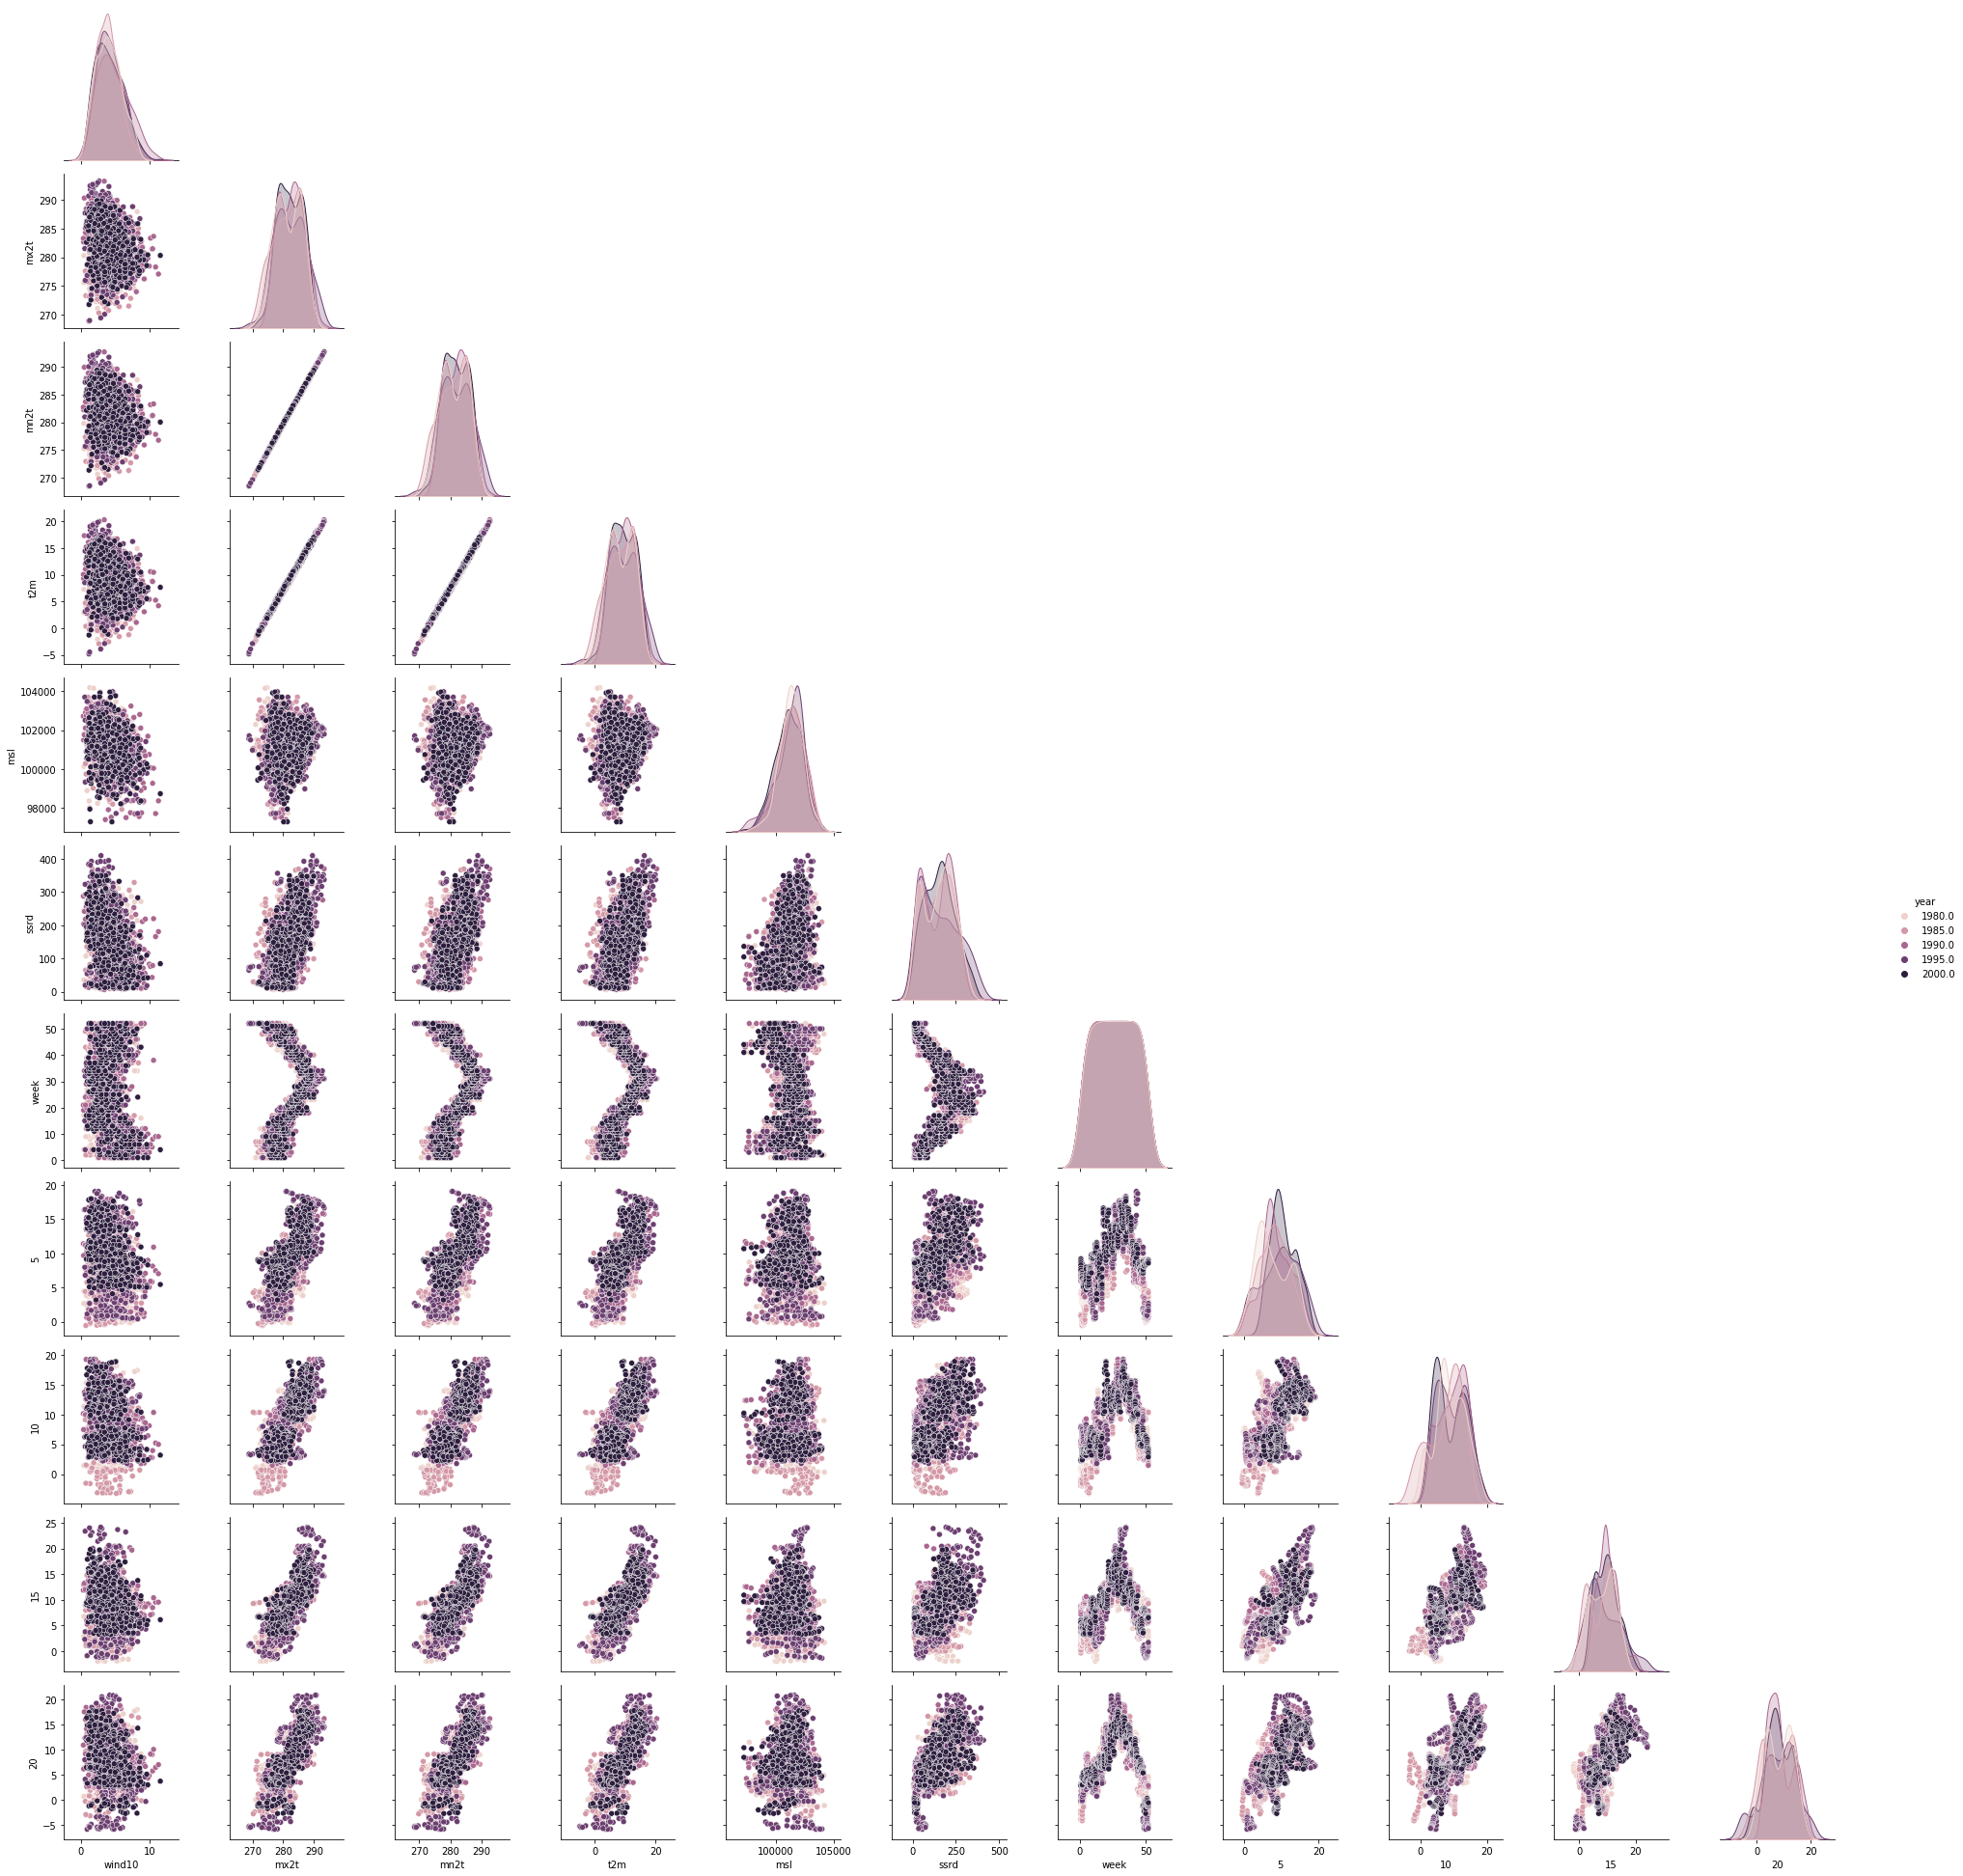

In [19]:
sns_plot = sns.pairplot(xy, hue = 'year' , corner = True)
sns_plot.savefig('plots/yearwise_input-output_correlation.png')

In [20]:
# mutual information is an alternative to pearson's correlation and is based on the entropy 
# between two variables, therefore it does not assume linearity.
# scikit learn provides a function to calculate the mutual information between two features 

from sklearn.feature_selection import mutual_info_regression

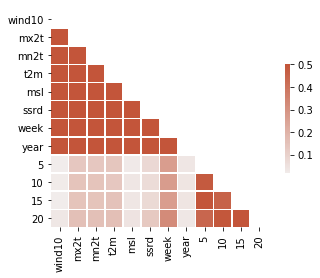

In [21]:
# The nan values have to be converted to 0

xy = xy.fillna(0)
df_mi= pd.DataFrame(columns = xy.columns)
for col in xy.columns:
    df_mi.loc["%s"%col] = mutual_info_regression(xy, xy[col])
mask = np.triu(np.ones_like(df_mi, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df_mi, mask=mask, cmap=cmap, center=0, square=True, vmax=0.5, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig("plots/yearly_input-output_correlation_mutual_information")